In [2]:
# Necessary Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# ML and Deep Learning Imports
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import Accuracy

from scipy.ndimage import gaussian_filter

In [4]:
# Mounting my GoogleDrive, so that I can access the local data folders through the Colab environment
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


------------------
# **Human Acitivity Recognition Using Labeled Smartphone Data**

### ***Project by Jonny Hofmeister***

***Capstone Project for Flatiron School Data Science Bootcamp***

This data was sourced from the UCI Machine Learning Repository - [
Smartphone-Based Recognition of Human Activities and Postural Transitions Data Set]('https://archive.ics.uci.edu/ml/datasets/Smartphone-Based+Recognition+of+Human+Activities+and+Postural+Transitions')

The data was collected by Davide Anguita, Alessandro Ghio, Luca Oneto, Xavier Parra, and Jorge L. Reyes-Ortiz at the University of Genova. Their paper [A Public Domain Dataset for Human Activity Recognition Using Smartphones]('https://www.esann.org/sites/default/files/proceedings/legacy/es2013-84.pdf') describes in-depth their process in collecting, processing, and labeling this data.




------------
## **Business Understanding**

The goal of this classification model is to use smartphone-based sensor data/information to determine what kind of activity the user is performing. There are 6 activities labeled and recorded in this data, three are static postures (Sitting, Standing, and Laying Down) and three dynamic activities (Walking, Walking Upstairs, and Walking Downstairs). The researchers have also labeled and included the transitions between these activities, but intial modeling attempts in this project will seek to classify just the initial 6 activities. 

Understanding the activities of persons can have large benefits towards understanding their health and daily patterns. Recognizing and recording these patterns can help determine how activites affect health, sleep, etc. For example, tracking time sitting down can help researches correlate time spent sitting to negative health effects and them begin to inform patients on how to change their activity patterns to improve health. 

Smartphones are something most people have on them most of the day, and therefore are a consistent way to record activity information. The downside, is that the location of the phone has a large influence on what the sensor data looks like for each activity. Having the phone in a back pocket vs in-hand while walking 'looks' different to the sensors and gyroscopes and thus limits our ability to properly classify the activity. In the long run, using data from consistently located sensors like smart-watches and fit-bands may provide more consistent results of a deployed model, but this readily-availble data from smartphones is a great place to begin research in creating models that can successfully classify activities. These researches recognized this location problem, and addressed it by consistently mounting the smartphone on the waist of all participants during the data collection process.

The researchers state "These mass-marketed devices provide a flexible, affordable and self-contained solution to automatically and unobtrusively monitor Activities of Daily Living" as a benefit of using smartphones to collect this data.


<img src='images/AdobeStock_367863903.jpeg' align=center width=700>
(Image from Adobe Stock)

--------------
## **Data Understanding**

The first step in understanding the data is to look at how it was collected. Conveniently, the researchers have provided [this video]('https://www.youtube.com/watch?v=XOEN9W05_4A') which shows an example of one of their collection trials.

### **Understanding the Features**

This dataset has been taken from the embedded accelerometer and gyroscopes in Samsung Galaxy II smartphones. The tri-axial (x, y, and z) signals were sampled a constant rate of 50Hz (50 samples per second). The sensor signals were then processed through noise filters and then sampled in 2.56 second sliding windows with 50% overlap - this corresponds to 128 readings per window.

Then from each sample window, variables from the time and frequency domain were calculated to obtain a vector of 561 features. It is this 561 feature vector for each window that we use as our data samples to train a model.

Lets explore exactly what these are. The time and frequency domain signals used to estimate the features are:

    - tBodyAcc-XYZ
    - tGravityAcc-XYZ
    - tBodyAccJerk-XYZ
    - tBodyGyro-XYZ
    - tBodyGyroJerk-XYZ
    - tBodyAccMag
    - tGravityAccMag
    - tBodyAccJerkMag
    - tBodyGyroMag
    - tBodyGyroJerkMag
    - fBodyAcc-XYZ
    - fBodyAccJerk-XYZ
    - vfBodyGyro-XYZ
    - fBodyAccMag
    - fBodyAccJerkMag
    - fBodyGyroMag
    - fBodyGyroJerkMag
    
Where 'XYZ' denotes the tri-axial signals.

Then to create the 561 feature vector, for each of the above signals, this set of variables was calcualted:

    - mean(): Mean value
    - std(): Standard deviation
    - mad(): Median absolute deviation 
    - max(): Largest value in array
    - min(): Smallest value in array
    - sma(): Signal magnitude area
    - energy(): Energy measure. Sum of the squares divided by the number of values. 
    - iqr(): Interquartile range 
    - entropy(): Signal entropy
    - arCoeff(): Autorregresion coefficients with Burg order equal to 4
    - correlation(): correlation coefficient between two signals
    - maxInds(): index of the frequency component with largest magnitude
    - meanFreq(): Weighted average of the frequency components to obtain a mean frequency
    - skewness(): skewness of the frequency domain signal 
    - kurtosis(): kurtosis of the frequency domain signal 
    - bandsEnergy(): Energy of a frequency interval within the 64 bins of the FFT of each window.
    - angle(): Angle between to vectors.
    
This is a lot of good data! As I mentioned in the above section, we don't want to manually perform feature selection from these 561 options and want to employ modeling techniques that do this for us. So, I use this entire dataset and all 561 features we have access to to train the models.

#### ***Test Subjects***

The data was collected from 30 volunteers who all underwent the same process for data collection as outlined in the video. Becasue of the time-series nature of the data and inconsistent amounts of data for each test subject and activity, I plan on using the train/test split the researchers have used, in which they select 70% of volunteers as training data, and 30% for testing. This is slightly different than dividing the number of samples of data by the same ratios. I also will not apply any shuffling to the data before modeling - we want the data grouped by subject and then by activity because this is likely how real life (not just validation data) will be input into the model.

### **Data Exploration**

#### ***Missing values***

The first thing I did was search the training and testing sets for missing values. This was a very well constructed dataset and contained zero NaN or Null values and therefore we will not need to employ and kind of imputation step in the preprocessing.

#### ***Class Distribution***

Next we explore the ditribution of the target classes in a bar plot shown below.

<img align="center" src="images/class_distribution.png">

While not perfectly balanced, the class distribution is fairly even. When considering the binary Dynamic vs Static groups, the imbalance is slightly greater. But given there is still a significant number of samples in the smaller class, I do not think it is necessary to weight or upsample one of the groups.

----------

## **Data Preparation**

Begin be extracting the feature names for the dataset.

In [5]:
# Open the features.txt file and read it into memory
file = open('/content/gdrive/MyDrive/capstone/data/HAPT_data_set/features.txt', 'r')
lines = file.readlines()

# Take the readline strings and split it into just feature names
columns = [line.replace('\n', '').strip() for line in lines]
file.close()

Unfortunately, not all the feature names are unique, so we must first sort through and make adjustments to the dupplicates.

In [6]:
# List to store feature names
unique_cols = []

# If a name is already in the unique cols list, we add it's index to the string so it becomes unique.
for idx, val in enumerate(columns):
    if val not in unique_cols:
        unique_cols.append(val)
    else:
        unique_cols.append(val+'__'+str(idx))

# Check the length
len(unique_cols)

561

Perfect, now we have all 561 feature names ready for importing the dataset. Below, I import the datafiles exactly as they are named and with the proper labels.

In [7]:
# Importing the training set with the unique feature names and then the Activity labels for the training set.
X_train = pd.read_csv('/content/gdrive/MyDrive/capstone/data/HAPT_data_set/Train/X_train.txt',
                      delimiter=' ', engine='python', header=None, names=unique_cols)
y_train = pd.read_csv('/content/gdrive/MyDrive/capstone/data/HAPT_data_set/Train/y_train.txt',
                      header=None, names=['Activity_Label'])

# Next, same thing for the Testing set.
X_test = pd.read_csv('/content/gdrive/MyDrive/capstone/data/HAPT_data_set/Test/X_test.txt',
                     delimiter=' ', engine='python', header=None, names=unique_cols)
y_test = pd.read_csv('/content/gdrive/MyDrive/capstone/data/HAPT_data_set/Test/y_test.txt',
                     header=None, names=['Activity_Label'])

Before I relabel this dataset for the first and second stage classifiers, I am going to join the features df with the labels df. This is to create a simple and consistent single dataframe for the Training and Testing sets I can easily manupilate before inputting it into the first or second stage classifier model. 

Then, I add another label column for the binary classification group, either 'Dynamic' or 'Static'. The dynamic activities are Walking, Walking Upstairs, and Walking Downstairs, and are numbered activities 1, 2 and 3. The static activities are Sitting, Standing, and Laying, and are labeled 4, 5 and 6. Labels 7 though 12 are transition activities, i.e. Sitting to Standing. This model will not attempt to classify these transitions, so we remove row instances with activity labels greater than 6.

In [8]:
# Join the labels and the features.
train = y_train.join(X_train)
test = y_test.join(X_test)

# Remove transition activites
train = train[train['Activity_Label'] < 7]
test = test[test['Activity_Label'] < 7]

# Add binary activity column for first stage classification
train['binary_activity'] = np.where(train['Activity_Label'] < 4, 'D', 'S')
test['binary_activity'] = np.where(test['Activity_Label'] < 4, 'D', 'S')

# Check the lengths and that the train test split ratio was retained after removing transition activities.
print(f'''Training set instances: {len(train)}
Testing set instances: {len(test)}
Train/Test Ratio: {int(len(train)/(len(train)+len(test))*100)}/{int(len(test)/(len(train)+len(test))*100)}''')

Training set instances: 7415
Testing set instances: 2996
Train/Test Ratio: 71/28


Awesome, now we have a Dataframe set up for the training and testing sets that can be easily subset for input into either of the three models we need to train (the first stage binary, and two second stage 3-class models). 

The training and testing split is just about 70/30. This corresponds to the split performed by the researchers. The data was split by subject, not random rows. We dont have exactly 70/30 because of slight variances in the subject's trials and the time spent in transition activities, which we removed. 

#### ***Scaling***

I do not apply any scaling or normalization techniques in this model. As the raw data has been processed and extracted for statistical features already, all features are in the range from -1 to 1. Also, the goal of this model isnt to extract information comparing the effect sizes of the different features. We want the model to automatically perform feature selection so we dont have to. For these reasons, mainly that the data is mostly normal and scaled to -1 to 1 already, I do not apply any scaling during the preprocessing.

#### ***Data Sharpening***

The final step of data preparation is to apply sharpening techniques to the features. But, we only want to sharpen the data for the 2nd stage of the model. So, I leave our 'train' and 'test' dataframes un-sharpened and apply the filters as we subset and construct the specific training and testing sets to for input to each of the three models.

----------

## **Modeling**

### **Process**

For this proof of concept HAR analysis, I employ the "Divide and Conquor" method proposed in [this research paper](https://www.mdpi.com/1424-8220/18/4/1055).

<img align="center" src="images/2_stage_classification.png" width="650">

*Credit for this image belongs to the authors of the Divide and Conquor Paper.*

This method breaks modeling up into 2 stages. First, we perform a binary classification that groups the data into Dynamic and Static activities. Then second, we perform two 3-class classifications for the 3 activities belonging to the dynamic and static groups. Walking, walking upstairs, and walking downstairs are dynamic activities. Sitting, standing, and laying are static activities.

### **First-Stage Binary Classifier**

The researchers who first proposed this method found that a decision tree was able to classify Dynamic and Static acivities with a perfect accuracy. Because of the known success of this method and the simplicity of decision trees/ random forests, I choose to implement one for the binary stage of my model.

While the researchers used a decision tree, I will implement a random forest because they can slightly reduce over-fitting and they do not take any more effort to employ than a decision tree. I will utilize the Sci-Kit Learn package to build this model.

We mentioned before that with so many features in our data, a model that can automatically perform feature selection is ideal. This is a strength of decision trees and random forests because each branch 'decision' is based off of feature conditions that are most important and influential. This makes our model quickly adaptable to new datasets.

In [9]:
# Begin my selecing the data and proper labels to train the first stage binary with.
X_train_binary = train.drop(['Activity_Label', 'binary_activity'], axis=1)
y_train_binary = train['binary_activity']

X_test_binary = test.drop(['Activity_Label', 'binary_activity'], axis=1)
y_test_binary = test['binary_activity']


# Now build the Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=1234,
                                n_estimators=40)

# Fit the RF on the training set
rf_clf.fit(X_train_binary, y_train_binary)

RandomForestClassifier(n_estimators=40, random_state=1234)

While training this model for the first time, the training and testing sets only had a couple incorrect predictions. I was able to balance this by adjusting only one hyperparameter - the number of estimators. A higher number of estimators (n=100) slightly overfit and would get a few of the test predictions wrong. A lower number of estimators (n=10) yeilded some incorrect guessed on the training set but was able to generalize the smaller testing set perfectly. After a few tries, I found that a middle ground of n_estimators=40 was able to balance generalization and overfitting and classify both training and testing perfectly.

### **Second-Stage 3-Class Models**

The two second stage models will both utilize neural networks and the Keras package. Both models will employ 1-dimensional convolutional methods/layers but will be structured slightly differently. I expereimented with slightly different constructions in these models, but they are both based off the second stage 1D CNN models proposed by [this HAR research paper]('https://www.mdpi.com/1424-8220/18/4/1055') I have previously mentioned.

### **"Dynamic" Activity 1-D Convolutional Neural Network**

The first thing that needs to be done is to select data samples only for dynamic activities. Walking, Walking Upstairs, and Walking Downstairs are labels 1, 2 and 3.  Next we split the training and testing sets into into the features (X) and labels (y). Since this is a 3 class model and not binary, we must One Hot Encode the target labels. We will do this using Keras to_categorical utility, which requires our labels begin at 0. To quickly fix this, we replace label class '3' with '0' and leave 1 and 2 unaltered.

Then we put this formatted data back into dataframes before our scaling step. For clarity, Walking Downstairs label is 0, Walking is 1, and Walking Upstairs is 2.

In [10]:
# Selecting just the dynamic activity data from training and testing sets
dynamic_train = train[train['Activity_Label'] <= 3]
dynamic_test = test[test['Activity_Label'] <= 3]

# Splitting into data and labels
# Training
X_train_dynamic = dynamic_train.drop(['Activity_Label', 'binary_activity'], axis=1)
y_train_dynamic = dynamic_train['Activity_Label']
# Testing
X_test_dynamic = dynamic_test.drop(['Activity_Label', 'binary_activity'], axis=1)
y_test_dynamic = dynamic_test['Activity_Label']

# The Keras util to_categorical requires the integers for labels begin at 0, the labels in this set are currently 1,2,3.
y_train_dynamic.replace(3, 0, inplace=True)
y_test_dynamic.replace(3, 0, inplace=True)

# Convert targets to OHE categorical
y_train_dynamic = to_categorical(y_train_dynamic)
y_test_dynamic = to_categorical(y_test_dynamic)
# And back to a pandas DataFrame
y_train_dynamic = pd.DataFrame(y_train_dynamic)
y_test_dynamic = pd.DataFrame(y_test_dynamic)


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


#### ***Sharpening***

Applying data sharpening before the second stage models was found to increase performance by the research paper. Their proposed method for sharpening is as follows:
  - Denoise the data with a gaussian filter.
  - Exctract details by subtracting the denoised result from the data.
  - Amplifying these details to some degree using a chosen parameter,
  - Then add these details back to the original data to obtain the sharpened result.

As mentioned before, we apply sharpening now as we do not want to use sharpened data in our 1st stage decision tree. We also sharpen separately for Dynamic and Static models so that we can slightly adjust the denoising and amplification amounts to best fit the differences in dynamic and static activity data.

In this case, the dynamic model applies a higher degree of detail amplification in order to produce higher contrast between activity signals than in the static model.

In [11]:
# Data sharpening
# Begin be denoising data with gaussian filter
sigma = 7
denoised_X_train_dynamic = gaussian_filter(X_train_dynamic, sigma=sigma)
denoised_X_test_dynamic = gaussian_filter(X_test_dynamic, sigma=sigma)

# The denoised result is subtracted from the test data to obtain sharped details
detailed_X_train_dynamic = X_train_dynamic - denoised_X_train_dynamic
detailed_X_test_dynamic = X_test_dynamic - denoised_X_test_dynamic

# The sharpened details are then amplified to some degree using α parameter and added to the original test data to obtain sharpened test data
alpha = 1.95
sharpened_X_train_dynamic = X_train_dynamic + (alpha * detailed_X_train_dynamic)
sharpened_X_test_dynamic = X_test_dynamic + (alpha * detailed_X_test_dynamic)

In [12]:
# Check the input shape
sharpened_X_train_dynamic.shape

(3286, 561)

Great, the features have been sharpened and targets encoded. We have 3286 samples in the Dynamic training set and the input dimensions for the neural network will be (561, 1) as we have 561 features that are all a single value.

##### ***CNN Construction***

The Dynamic activity classification model is a 1-D convolutional neural network. We utilize a single 1D convolution layer followed by a Max pooling layer. The kernel size of the convolution is set to the stride size for the pooling layer. "ReLu" is the activation function we use for the convolutional layer. 

After the convolutional step, we flatten the nueral network, apply a dropout layer at a rate of 0.5 to help reduce overfitting, and finally a output layer with 'softmax' activation.

In [35]:

# Building the "Dynamic" CNN Classifier
dynamic_cnn = Sequential([
  # Begin with the 1D Convolution, window and stride of 3
  layers.Conv1D(100, kernel_size=3, input_shape=(561, 1), activation='relu'),
  # Pooling Layer
  layers.MaxPooling1D(strides=3),
  # Flattening layer
  layers.Flatten(),
  # Dense layer with 50% dropout
  layers.Dropout(.5),
  # Output layer, 3-class softmax
  layers.Dense(3, activation='softmax')
])

In [36]:
dynamic_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 559, 100)          400       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 186, 100)         0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 18600)             0         
                                                                 
 dropout_3 (Dropout)         (None, 18600)             0         
                                                                 
 dense_3 (Dense)             (None, 3)                 55803     
                                                                 
Total params: 56,203
Trainable params: 56,203
Non-trainable params: 0
__________________________________________________

56 thousand trainable parameters is relatively low, so this model will train quickly. We select the Adam optimizer, MSE as our loss function, and score the model on accuracy.

We use the standard batch size of 32. During intial exploration, this model learned, but slowly. So, we set the number of epochs very high, 500, to give the model time to improve. This is feasible because each epoch trains in only 4 seconds.

In [ ]:
dynamic_cnn.compile(optimizer='adam',
                    loss=MeanSquaredError(),
                    metrics=[Accuracy()])

epochs = 500

dynamic_cnn_results = dynamic_cnn.fit(
    x = sharpened_X_train_dynamic, 
    y = y_train_dynamic,
    validation_data=[sharpened_X_test_dynamic, y_test_dynamic],
    epochs = epochs,
    batch_size = 32
)

The model has been trained and results stored. So that we don't have to re-run the model to extract results, the below cell includes code to save and import the model. Note that this code is specific for my Google Colab environment.

In [13]:
# Save model
# dynamic_cnn.save('/content/gdrive/MyDrive/capstone/models/dynamic_cnn')

# Load model
# dynamic_cnn = keras.models.load_model('/content/gdrive/MyDrive/capstone/models/dynamic_cnn')

### **"Static" Activity 1-D Convolutional Neural Network**

Begin by selecting the static activity samples from the training and testing sets. Same exact process as above with the dynamic model.

In [14]:
# Selecting just the static activity data from training and testing sets
static_train = train[train['Activity_Label'] > 3]
static_test = test[test['Activity_Label'] > 3]

# Splitting into data and labels
# Training
X_train_static = static_train.drop(['Activity_Label', 'binary_activity'], axis=1)
y_train_static = static_train['Activity_Label']
# Testing
X_test_static = static_test.drop(['Activity_Label', 'binary_activity'], axis=1)
y_test_static = static_test['Activity_Label']

# The Keras util to_categorical requires the integers for labels begin at 0, the labels in this set are currently 1,2,3.
y_train_static.replace([4, 5, 6], [0, 1, 2], inplace=True)
y_test_static.replace([4, 5, 6], [0, 1, 2], inplace=True)

# Convert targets to OHE categorical
y_train_static = to_categorical(y_train_static)
y_test_static = to_categorical(y_test_static)
# And back to a pandas DataFrame
y_train_static = pd.DataFrame(y_train_static)
y_test_static = pd.DataFrame(y_test_static)


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


#### ***Sharpening***

Next, the data is sharpened with the same process as above. The only differences are the sigma and alpha parameters used in the gaussian filter and amplification. The alpha value in this case does not amplify the details nearly as much as for the previous model. These parameters are suggested by the researchers.

In [15]:
# Data sharpening
# Begin be denoising data with gaussian filter
sigma = 8
denoised_X_train_static = gaussian_filter(X_train_static, sigma=sigma)
denoised_X_test_static = gaussian_filter(X_test_static, sigma=sigma)

# The denoised result is subtracted from the test data to obtain sharped details
detailed_X_train_static = X_train_static - denoised_X_train_static
detailed_X_test_static = X_test_static - denoised_X_test_static

# The sharpened details are then amplified to some degree using α parameter and added to the original test data to obtain sharpened test data
alpha = 0.07
sharpened_X_train_static = X_train_static + (alpha * detailed_X_train_static)
sharpened_X_test_static = X_test_static + (alpha * detailed_X_test_static)

In [16]:
# Check the input shape
sharpened_X_train_static.shape

(4129, 561)

The static model contains more training samples than the dynamic set, almost a thousand more. This will benefit performance and slightly reduce training time. We still have the same (561, 1) features input dimension for the neural network.

***Static Model Construction*** 

The 1D CNN for the static activity classification is slightly different. Rather than utilizing a Max Pooling layer, we employ 3 consecutive 1D convolution layers with an increasing number of filters. The window size and activation function used for the Conv layers is still 3 and 'ReLu' respectively. The second half of this model matches the dynamic classifier with a flattening layer, a dense/dropout layer set to 0.5 dropout, and a 3 class 'softmax' output layer. 

In [24]:
# Building the "Dynamic" CNN Classifier
static_cnn = Sequential([
  # Static model contains 3 progressive 1D convolution layers
  layers.Conv1D(30, kernel_size=3, input_shape=(561, 1), activation='relu'),
  layers.Conv1D(50, kernel_size=3, activation='relu'),
  layers.Conv1D(100, kernel_size=3, activation='relu'),
  # Flatten layer
  layers.Flatten(),
  # Dense layer with 50% dropout
  layers.Dropout(.5),
  # Output layer, 3-class softmax
  layers.Dense(3, activation='softmax')
])

In [25]:
static_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 559, 30)           120       
                                                                 
 conv1d_2 (Conv1D)           (None, 557, 50)           4550      
                                                                 
 conv1d_3 (Conv1D)           (None, 555, 100)          15100     
                                                                 
 flatten_1 (Flatten)         (None, 55500)             0         
                                                                 
 dropout_1 (Dropout)         (None, 55500)             0         
                                                                 
 dense_1 (Dense)             (None, 3)                 166503    
                                                                 
Total params: 186,273
Trainable params: 186,273
Non-tr

In [ ]:
static_cnn.compile(optimizer='adam',
                    loss=MeanSquaredError(),
                    metrics=[Accuracy()])

epochs = 444

static_cnn_results = static_cnn.fit(
    x = sharpened_X_train_static, 
    y = y_train_static,
    validation_data=[sharpened_X_test_static, y_test_static],
    epochs = epochs,
    batch_size = 32
)

In [ ]:
# Save model
# static_cnn.save('/content/gdrive/MyDrive/capstone/models/static_cnn')

# Load model
# static_cnn = keras.models.load_model('/content/gdrive/MyDrive/capstone/models/static_cnn')

## **Evaluation**
------

### **First Stage Binary Prediction Evaluation**

To evaluate the first stage model we need to check performance on the training and testing sets. For the training set, I generate predictions and compute and accuracy score based on the true labels.

In [18]:
# Checking training set accuracy
train_preds_binary = rf_clf.predict(X_train_binary)
print(f'1st Stage Training Accuracy: {accuracy_score(y_train_binary, train_preds_binary)}')

1st Stage Training Accuracy: 1.0


Perfect score on the training set! Next let's see how well the model generalized to the testing data. Below I plot a confusion matrix to show a better visual of the results than just a score.

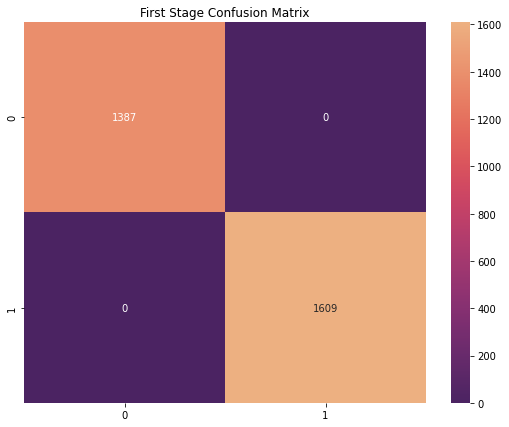

In [19]:
# Generate predictions from the test set
binary_preds = rf_clf.predict(X_test_binary)

# Get the confusion matrix
cf_matrix = confusion_matrix(y_test_binary, binary_preds)

# Make it pretty with seaborn
fig, ax = plt.subplots(figsize=(9, 7))

sns.heatmap(cf_matrix, annot=True, fmt="d", ax=ax, cmap='flare_r')
ax.set_title('First Stage Confusion Matrix');

Awesome, we perfectly classified the testing set too! Now that we have successfully grouped the activities into Dynamic and Static groups, we have eliminated a lot of error and uncertainty for the second stage models. Time to see how those performed.

### **Second Stage 1D CNN "DYNAMIC Activity" Model Evaluation**

To evaluate the training and performace of our CNNs, let's plot the evolution of the model accuracy and loss as we progressed through training epochs. The loss function we employed was mean squared error, and accuracy is simply the success rate for all predictions.

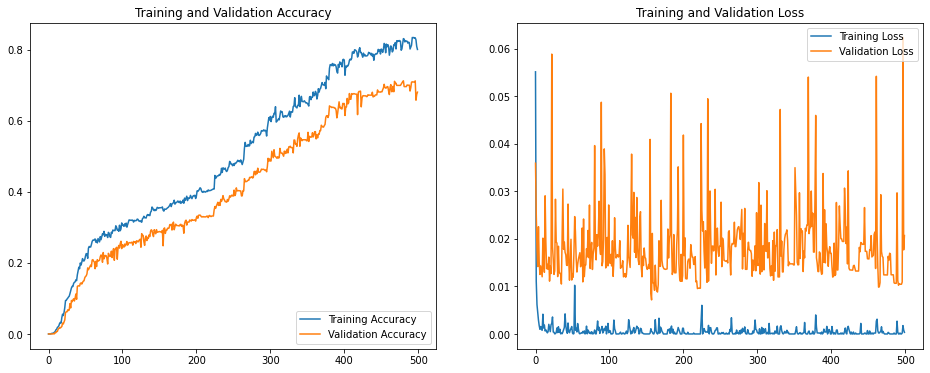

In [38]:
dy_acc = dynamic_cnn_results.history['accuracy']
dy_val_acc = dynamic_cnn_results.history['val_accuracy']

dy_loss = dynamic_cnn_results.history['loss']
dy_val_loss = dynamic_cnn_results.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, dy_acc, label='Training Accuracy')
plt.plot(epochs_range, dy_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, dy_loss, label='Training Loss')
plt.plot(epochs_range, dy_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss');

The dynamic activity classification scored around 80% accuracy for the training set and about 65% accuracy for the testing set. This isn't bad, and it appears from the accuracy score that the model had not quite plateaued and could possibly learn even more from the data. Another thing to notice is that the learning patterns for training and testing matched well. For example, around the 210th epoch, the accuracy scores in both sets started to trend upwards more quickly. This implies that patterns found in the training set are generalizing to the testing data very well - this is awesome.

### **Second Stage 1D CNN "STATIC Activity" Model Evaluation**

Next, let's perform the same evaluation for the Static activity model.

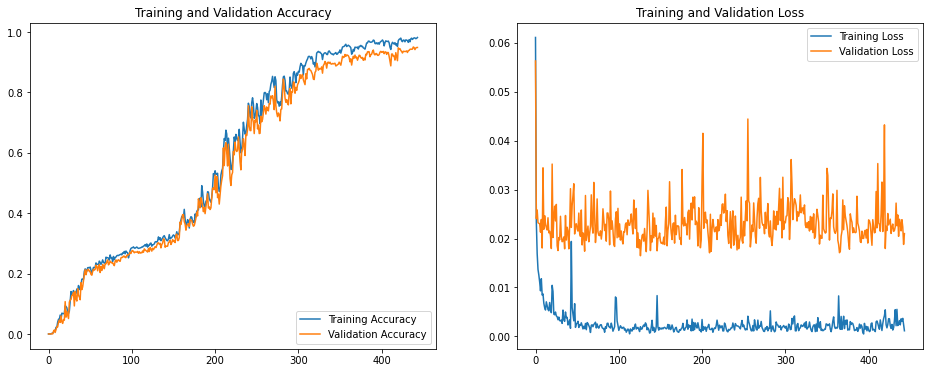

In [27]:
st_acc = static_cnn_results.history['accuracy']
st_val_acc = static_cnn_results.history['val_accuracy']

st_loss = static_cnn_results.history['loss']
st_val_loss = static_cnn_results.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, st_acc, label='Training Accuracy')
plt.plot(epochs_range, st_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, st_loss, label='Training Loss')
plt.plot(epochs_range, st_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss');

The Static activity model did excellent, training and testing scores were both above 95% in the later epochs. Loss scores for testing were slightly higher than training as expected, but both still very low. 

As in the dynamic model, we see a correlation in learning (accuracy score increase) in the training and testing sets. This implies the patterns learned in training are also found in the testing set and that the model should be fairly generalizable and robust. Overall, I am very happy with the result in this model and it is certainly good enough to move forward with.

### **Overall Model Evaluation**

To visualize the results of the end-to-end model, we will return the predictions to their original labels, and concatenate the dynamic and static sets. Fortunately this is easy to do because the first stage model had 100% accuracy.

In [20]:
# Start-to-finish Confusion Matrix - Testing set

# Make a dictionary for the integer labels and activity classes
# Note I retain Walking upstairs as 0 (instead of 3), but change the static labels back to 4,5,6.
activity_dict = {0: 'WU', 1:'W', 2:'WD', 4:'SIT', 5:'STAND', 6:'LAY'}

# Test predictions from Dynamic model
dynamic_preds = dynamic_cnn.predict(sharpened_X_test_dynamic)
dynamic_preds = dynamic_preds.argmax(axis=-1)

static_preds = static_cnn.predict(sharpened_X_test_static)
static_preds = pd.DataFrame(static_preds.argmax(axis=-1)) # turn into DF so we can use df.replace() method
# Convert static numeric labels back to 4, 5, 6 so we can tell them apart from dynamic
static_preds.replace([0,1,2], [4,5,6], inplace=True)
static_preds = np.transpose(np.asarray(static_preds))[0] # turn back into an array

# Preds into single array
preds = np.append(dynamic_preds, static_preds)

# Now gather the true labels
true_dy = np.asarray(y_test_dynamic).argmax(axis=-1)
true_st = pd.DataFrame(np.asarray(y_test_static).argmax(axis=-1))
true_st.replace([0,1,2], [4,5,6], inplace=True)
# True into single array
true = np.append(true_dy, true_st)

# Check the lengths match
len(preds) == len(true)

True

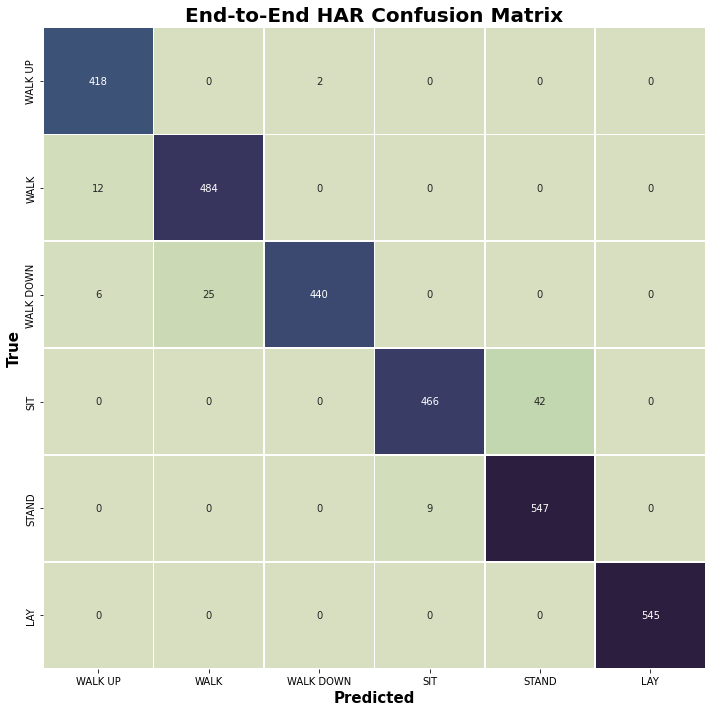

In [44]:
# Now plot the complete confusion matrix
cf_matrix = confusion_matrix(true, preds)

# Define the proper labels - I determined the order by manually checking counts
labels = ['WALK UP', 'WALK', 'WALK DOWN', 'SIT', 'STAND', 'LAY']

# Make it pretty with seaborn
fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(cf_matrix, annot=True, 
            xticklabels=labels, yticklabels=labels,
            fmt="d", ax=ax, cmap=sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True),
            linewidths=0.5, linecolor='w', cbar=False)
ax.set_title('End-to-End HAR Confusion Matrix', fontdict={'fontsize': 20, 'weight': 'bold'})
ax.set_xlabel('Predicted', fontdict={'fontsize': 15, 'weight': 'heavy'})
ax.set_ylabel('True', fontdict={'fontsize': 15, 'weight': 'bold'})
plt.tight_layout();

These are the final results of the end to end 2-stage HAR prediction model. One can finally see the strength of the 1st stage binary classifier here by examining the lower left and upper right quadrants of the confusion matrix - they are all zeros. This makes sure we never mis-classify a dynamic activity as static or vice versa. This step will also significantly increase the overall accuracy of the model.

The most mis-classified activity was sitting. This model predicting standing 42 times when the true label was sitting. The second most mixed-up activity was predicting walking when the true label was walking down. 25 and 42 mis classifications are very insignificant given thousands of samples. Also, it is important to note it might not be as bad to mix up two dynamic or two static activites as it might be to mix up a dynamic activity for a static one. This is another strength of a strong first stage model.

Lets's figure out what the actual accuracy score for the model is below.

In [26]:
# Compute overall accuracy score
print(f'Overall Model Accuracy Score: {accuracy_score(true, preds):.2f}')

Overall Model Accuracy Score: 0.97


An overall accuracy of 97% is awesome for a proof of concept analysis. I think the strength of this model comes from a first stage model that can precisely split the data by dynamic and static activities. This eliminates a huge number of misclassification possiblities and allows for more precise/specific models in the second stage. 

#### Sharpening Success

I must also directly note the value of adding the data sharpening techniques proposed by the research paper. I attempted modeling without sharpening, and was unable to acheive accuracy scores above 45% in the dynamic 2nd stage model. The sharpening step is essential to the second stage models and also allows us to tweak the models more precisely.

## **Next Steps**

### **Improvements**

The Binary and Static models acheived perfect and near perfect accuracy scores. But the Dynamic model was slightly lacking compared to its siblings. I think moving forward, one of the first things to do is tweak the dynamic model until it performs as well as its second stage static counterpart.

Improving the dynamic model could be done by changing the structure and layers of the 1-D CNN, or by adjusting the parameters involved in the data sharpening step. The research paper outlines many possibilites of combinations of successful sharpening parameters, and trying these would be my first step before adjusting the CNN structure. 

We also had almost 1000 more training samples in the static model than in the dyanmic model. This also has an effect on how much the model can learn. So improving the dynamic model scores could also come from simply aquiring more data.

### **Streamlining**

Since this model so far is a proof of concept for a 2 stage model, it is broken up into 3 different models that must be run separately. Another next step now that we have created good enough models is to pipe them all together end-to-end. While improving and exploring models might be best done on each model separately as I have done here, testing this model on new data or deploying it would be much easier if it were all piped into a single function/model.

### **Deployment Details**

Also within the context of deployment, we next need to consider how data will be input and output and what information we want to extract from the model.

Here, single row instances are classified into activity. In practice, we are more likely to input many consecutive samples/rows in time into the model. This would then output a prediction for activity for each window in time. We would then have to decide if we wanted the model to return the most likely or frequent activity for all the data input, or a breakdown of the different activities used. One example for a minute of sensor data could be to classify all rows, choose the most likely activity for each second, and then return information about how much time the user spent doing walking or doing a static activity. This is the kind of information that then becomes actionable to the user and tells them about their activity patterns through the day and how it relates to other health information like heart rate or blood pressure.

<img src='images/AdobeStock_122055934.jpeg' align=center width=600>
Image from Adobe Stock.

### **Resources / References**
Data:
  - [UCI](https://archive.ics.uci.edu/ml/datasets/Smartphone-Based+Recognition+of+Human+Activities+and+Postural+Transitions)
  - [Data Aquisition Paper](https://www.esann.org/sites/default/files/proceedings/legacy/es2013-84.pdf)

Tools / Packages:
  - [Tensorflow](https://www.tensorflow.org/api_docs/python/tf)
  - [Sci-Kit Learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=random%20forest#sklearn.ensemble.RandomForestClassifier)

References / Sources:
  - [Divide and Conquor HAR Research paper](https://www.mdpi.com/1424-8220/18/4/1055)
  - [Machine Learning Mastery - Summary of the different HAR research methods](https://machinelearningmastery.com/deep-learning-models-for-human-activity-recognition/)
  - [ML Mastery - 1D CNN for HAR](https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/)



  -----



**Analysis by Jonny Hofmeister. Thanks for reading!**